## Importing Libraries and Datasets

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving News (1).csv to News (1).csv


In [3]:
import io
data = pd.read_csv(io.BytesIO(uploaded['News (1).csv']))
data.head()

,Unnamed: 0,title,text,subject,date,class
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## Data Preprocessing

In [4]:
data.shape

(44919, 6)

In [5]:
data = data.drop(['title', 'subject', 'date'], axis=1)

In [6]:
data.isnull().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

In [7]:
# Shuffling

data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

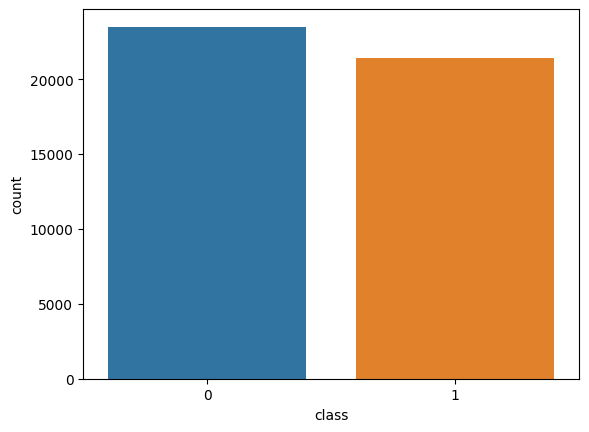

In [8]:
sns.countplot(data=data, x='class', order=data['class'].value_counts().index)

## Preprocessing and analysis of News column

In [9]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def preprocess_text(text_data):
  preprocessed_text = []

  for sentence in tqdm(text_data):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    preprocessed_text.append(' '.join(token.lower()
    for token in str(sentence).split()
    if token not in stopwords.words('english')))

  return preprocessed_text

In [11]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [35:57<00:00, 20.82it/s]


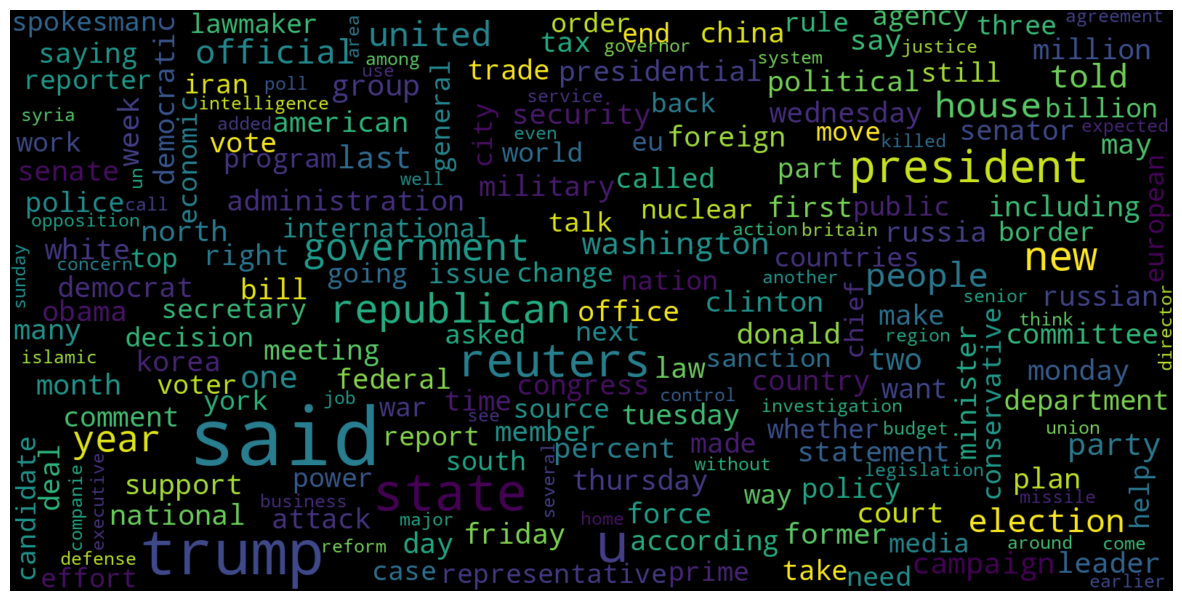

In [12]:
# Real

consolidated = ' '.join(
    word for word in data['text'][data['class'] ==1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations = False)

plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


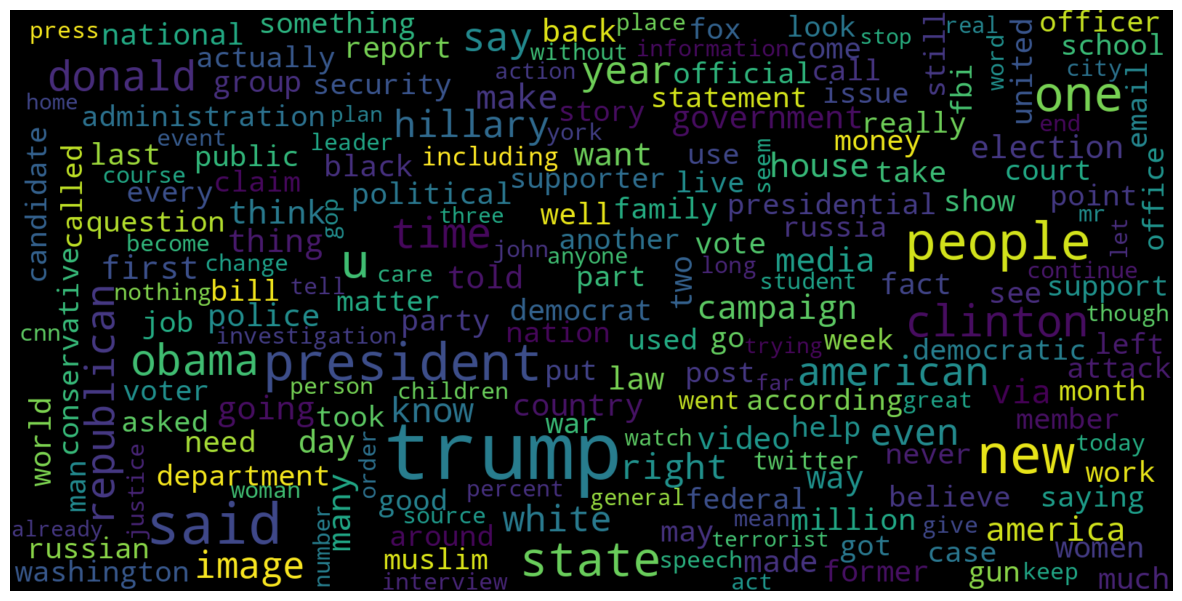

In [13]:
# Fake

consolidated = ' '.join(
    word for word in data['text'][data['class'] ==0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations = False)

plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='count'>

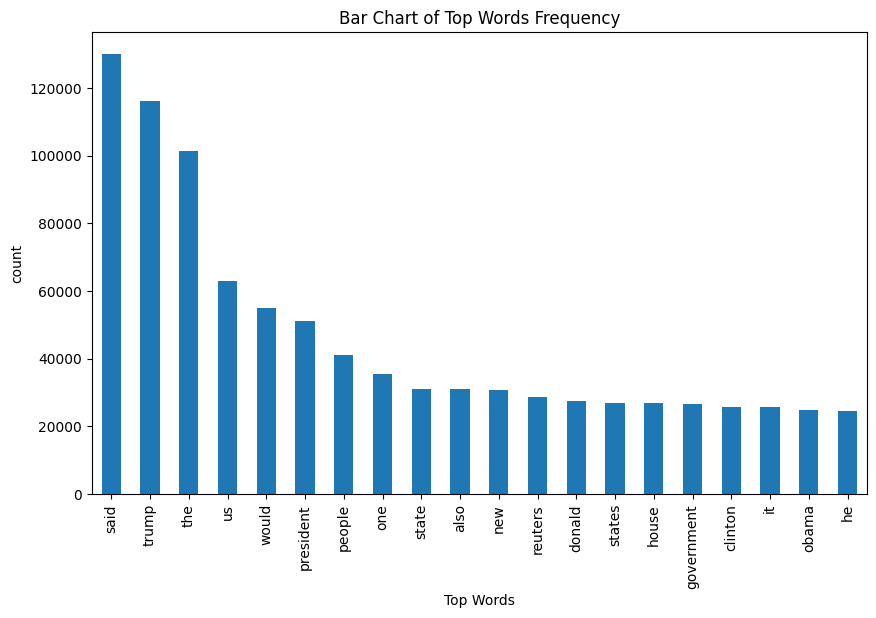

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
  vec = CountVectorizer().fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx])
  for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
  return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10,6),
    xlabel="Top Words",
    ylabel="count",
    title="Bar Chart of Top Words Frequency"
)



## Converting text into Vectors

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data['text'],
                                                    data['class'],
                                                    test_size=0.25)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

## Model training, Evaluation, and Prediction

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9933806286918578
0.9889581478183437


In [19]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))


1.0
0.9965271593944791


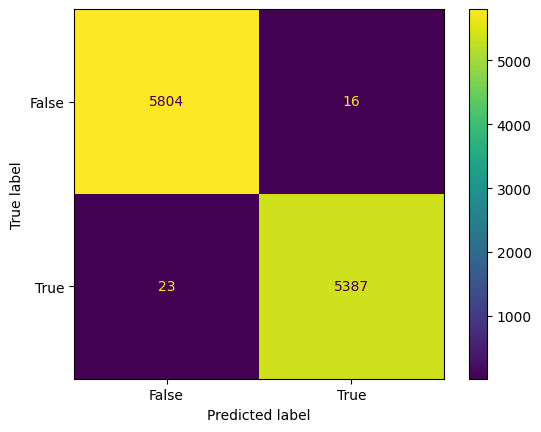

In [20]:
# Confusion matrix of Results from Decision Tree Classification

from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])

cm_display.plot()
plt.show()